In [2]:
import cv2
import matplotlib.pyplot as plt
import os


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


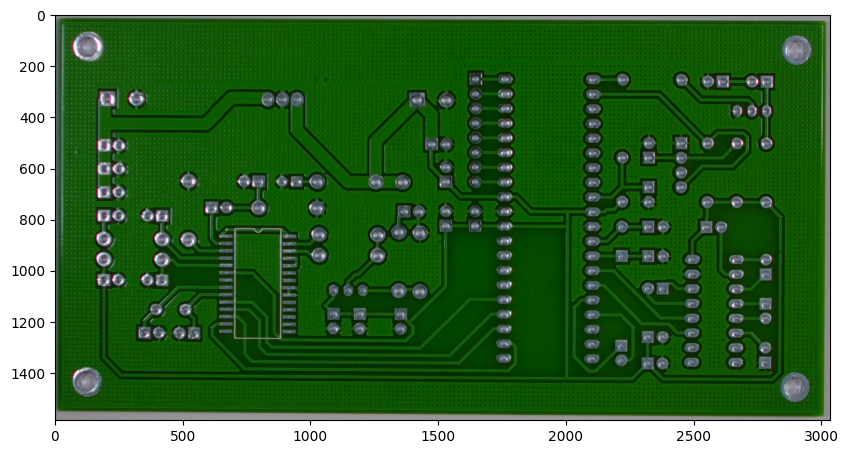

In [11]:
# read template PCB 01 image
rgb_template_img = cv2.imread('/content/drive/MyDrive/PCB_DATASET/PCB_USED/01.JPG')

# display original template PCB image
plt.figure(figsize=(10,6))
plt.imshow(rgb_template_img, cmap="gray")

In [12]:
rgb_template_img.shape

(1586, 3034, 3)

In [13]:
a = int(rgb_template_img.shape[0]/4)
b = int(rgb_template_img.shape[1]/4)

In [14]:
a,b

(396, 758)

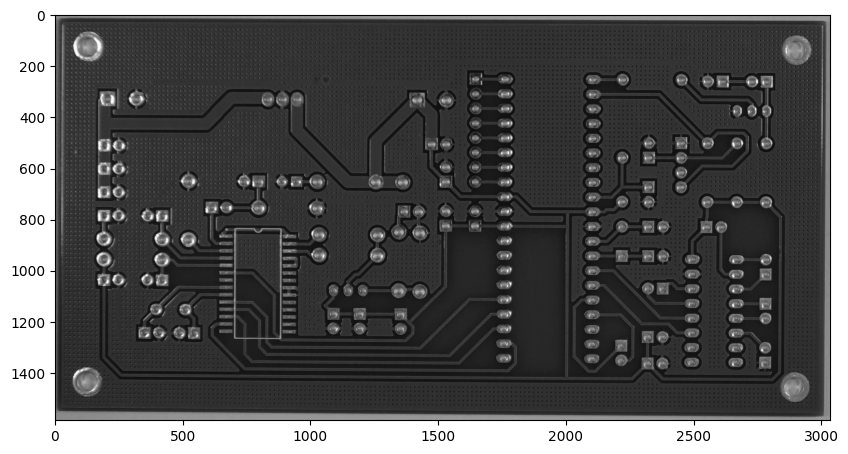

In [15]:
# read template PCB 01 image as grayscale image
template_img = cv2.imread('/content/drive/MyDrive/PCB_DATASET/PCB_USED/01.JPG', 0)
# the 2nd parameter is flag, makes image grayscale for value 0 or 2

# display the grayscale template PCB image
plt.figure(figsize=(10,6))
plt.imshow(template_img, cmap="gray")

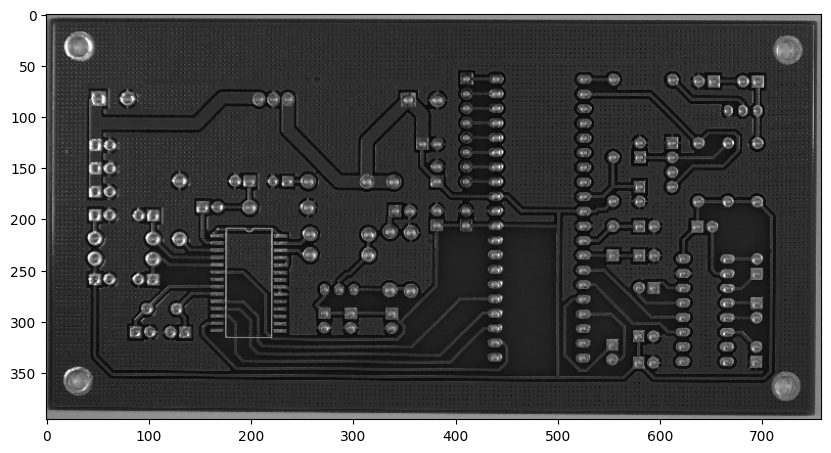

In [16]:
# resize template image of PCB
template_img_resize = cv2.resize(template_img, (b,a))

# display the grayscale resized template PCB image
plt.figure(figsize=(10,6))
plt.imshow(template_img_resize, cmap="gray")

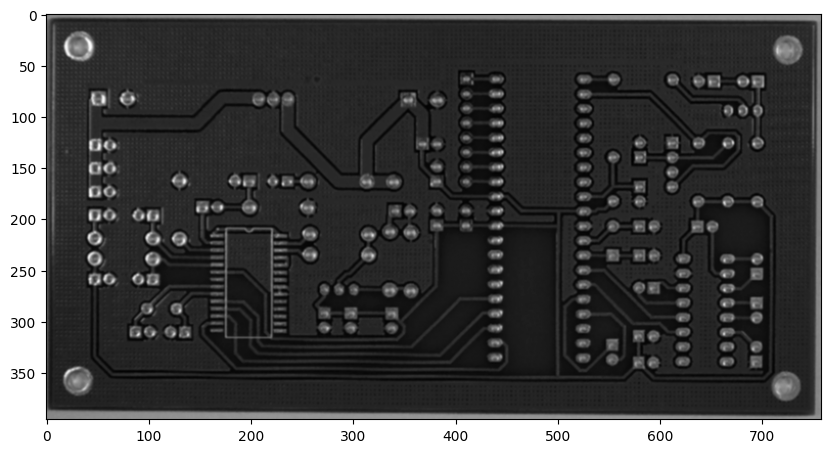

In [17]:
# Gaussian blur to blur the image before thresholding
blur_template_img = cv2.GaussianBlur(template_img_resize, (3,3),0)

# display the blurred image
plt.figure(figsize=(10,6))
plt.imshow(blur_template_img, cmap="gray")

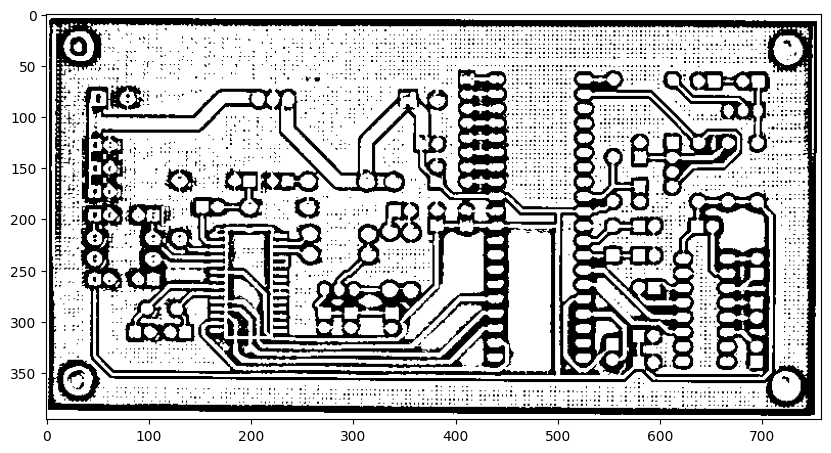

In [81]:
template_adap_thresh = cv2.adaptiveThreshold(blur_template_img, 255,
                                         cv2.ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 15, 5)

# display the thresholded image
plt.figure(figsize=(10,6))
plt.imshow(template_adap_thresh, cmap="gray")

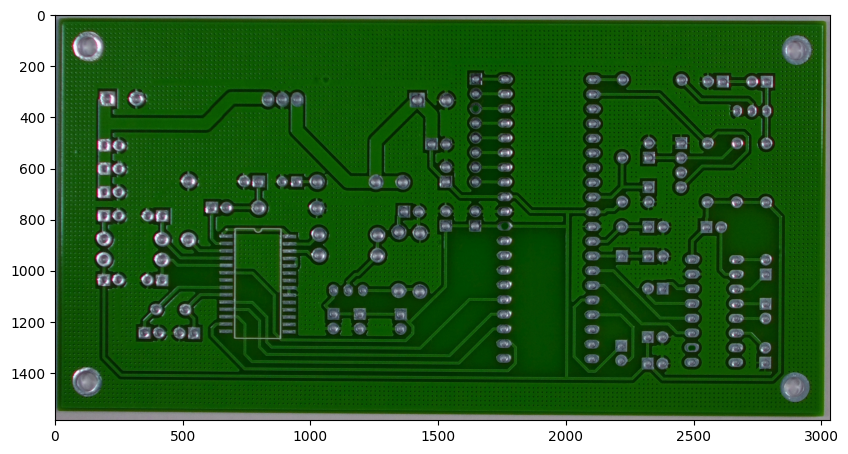

In [82]:
# read test image of PCB 01
rgb_test_img = cv2.imread('/content/drive/MyDrive/PCB_DATASET/images/Missing_hole/01_missing_hole_01.jpg')

# display original test PCB image
plt.figure(figsize=(10,6))
plt.imshow(rgb_test_img, cmap="gray")

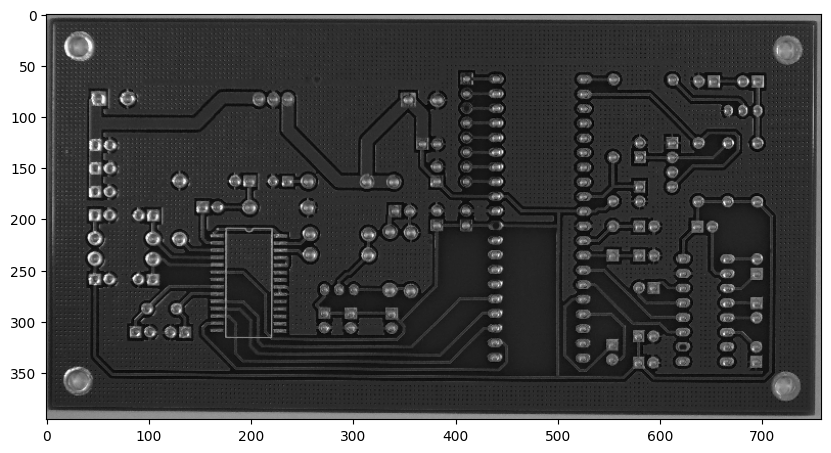

In [83]:
# read grayscale test PCB image
test_img = cv2.imread('/content/drive/MyDrive/PCB_DATASET/images/Missing_hole/01_missing_hole_01.jpg', 0)

# resize test image of PCB
test_img_resize = cv2.resize(test_img, (b,a))

# display the grayscale resized test PCB image
plt.figure(figsize=(10,6))
plt.imshow(test_img_resize, cmap="gray")

In [88]:
blur_test_img = cv2.GaussianBlur(test_img_resize, (3,3),0)

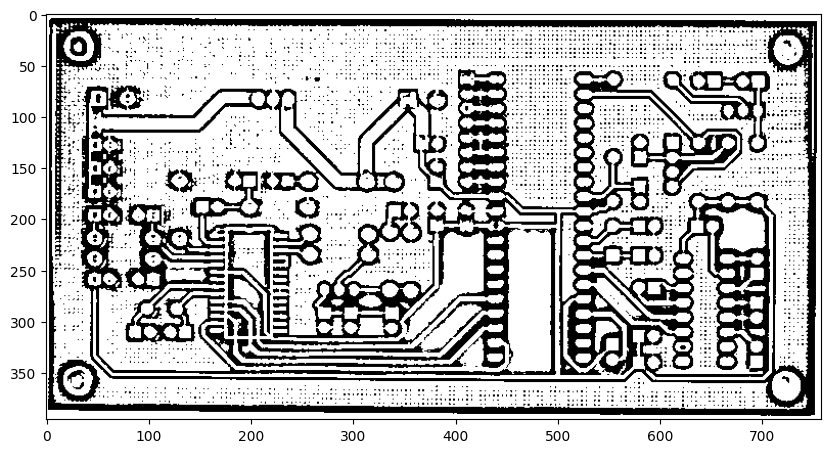

In [89]:
# Gaussian blur to blur the image before thresholding
blur_test_img = cv2.GaussianBlur(test_img_resize, (3,3),0)

# Adaptive thresholding(mean) on test image
test_adap_thresh = cv2.adaptiveThreshold(blur_test_img, 255,
                                         cv2. ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 15, 5)

# display the thresholded test image
plt.figure(figsize=(10,6))
plt.imshow(test_adap_thresh, cmap="gray")

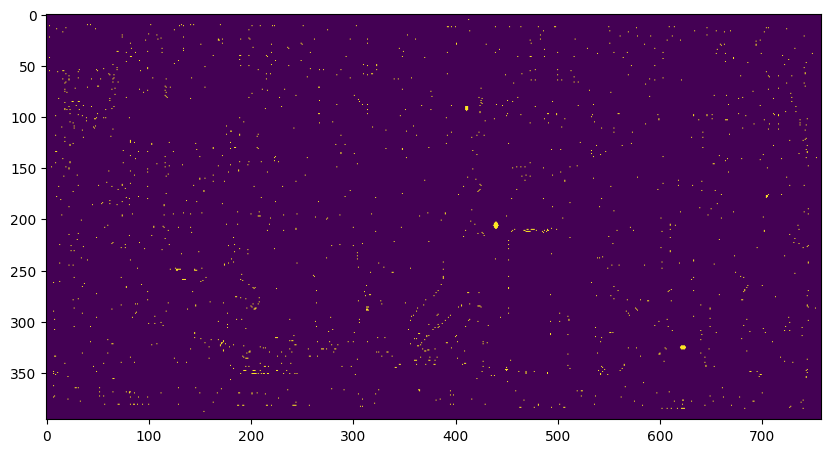

In [90]:
# Image subtraction (template - test)

sub_img= cv2.subtract(template_adap_thresh,test_adap_thresh)

# display resultant image after subtraction
plt.figure(figsize=(10,6))
plt.imshow(sub_img)

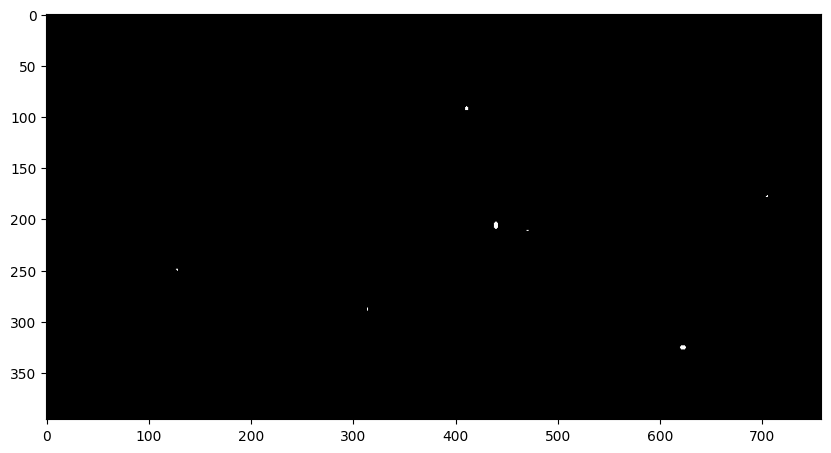

In [91]:
# Median blur to eliminate background noise
final_img = cv2.medianBlur(sub_img, 3)

# display final binary image result
# to show defects in the image
plt.figure(figsize=(10,6))
plt.imshow(final_img, cmap="gray")

In [98]:
# contour detection to get the count of defects
cnts = cv2.findContours(final_img, cv2.RETR_LIST,
                        cv2.CHAIN_APPROX_SIMPLE)[-2]
blobs = []
for cnt in cnts:
    if 1<cv2.contourArea(cnt)<300:
        blobs.append(cnt)

print("Number of defects in image:")
print(len(blobs))

Number of defects in image:
3


In [141]:
orig = test_img_resize
mask_img = final_img

In [142]:
out_dir = "/content/drive/MyDrive/PCB_DATASET/PCB_USED/Missing_Hole_Defect"

In [143]:
os.makedirs(out_dir, exist_ok=True)

In [144]:
_, thresh = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST,
cv2.CHAIN_APPROX_SIMPLE) # CHANGE ***

In [145]:
h_img, w_img = mask_img.shape[:2]

In [146]:
mask_img.shape

(396, 758)

In [152]:

patch_id = 0
for cnt in contours:
    if 1<cv2.contourArea(cnt)<300: # CHANGE ***

      x, y, w, h = cv2.boundingRect(cnt) # bounding rect of defect region [web:8][web:28]

      # Center of defect
      cx = x + w // 2
      cy = y + h // 2

      # Fixed 20x20 box
      bw, bh = 64,64
      x0 = cx - bw // 2
      y0 = cy - bh // 2
      x1 = x0 + bw
      y1 = y0 + bh

      # Clip to image bounds
      x0 = max(0, x0)
      y0 = max(0, y0)
      x1 = min(w_img, x1)
      y1 = min(h_img, y1)

      # Crop from ORIGINAL image using same coords

      patch = orig[y0:y1, x0:x1]

      # Optional: ensure patch is 20x20 (skip if smaller at borders)
      if patch.shape[0] != bh or patch.shape[1] != bw:
        continue

      # Save patch
      out_path = os.path.join(out_dir, f"defect_{patch_id:04d}.png")
      cv2.imwrite(out_path, patch) # save ROI patch [web:21][web:28]
      patch_id += 1




In [160]:
import cv2
import matplotlib.pyplot as plt
import os
from google.colab import drive

drive.mount('/content/drive')

base_dir    = "/content/drive/MyDrive/PCB_DATASET"
template_dir = os.path.join(base_dir, "PCB_USED")                # templates
test_dir     = os.path.join(base_dir, "images/Missing_hole")     # defect images

# ONE common output folder for all patches
out_dir = os.path.join(base_dir, "PCB_USED/Missing_Hole_Defect_ALL")
os.makedirs(out_dir, exist_ok=True)

def process_pcb(template_path, test_path, pcb_name):
    rgb_template_img = cv2.imread(template_path)
    a = int(rgb_template_img.shape[0] / 4)
    b = int(rgb_template_img.shape[1] / 4)

    template_img = cv2.imread(template_path, 0)
    template_img_resize = cv2.resize(template_img, (b, a))

    blur_template_img = cv2.GaussianBlur(template_img_resize, (3, 3), 0)
    template_adap_thresh = cv2.adaptiveThreshold(
        blur_template_img, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 15, 5
    )

    test_img = cv2.imread(test_path, 0)
    test_img_resize = cv2.resize(test_img, (b, a))
    blur_test_img = cv2.GaussianBlur(test_img_resize, (3, 3), 0)

    test_adap_thresh = cv2.adaptiveThreshold(
        blur_test_img, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, 15, 5
    )

    sub_img = cv2.subtract(template_adap_thresh, test_adap_thresh)
    final_img = cv2.medianBlur(sub_img, 3)

    cnts = cv2.findContours(final_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]
    blobs = [cnt for cnt in cnts if 1 < cv2.contourArea(cnt) < 300]
    print(f"{pcb_name}: {len(blobs)} defects")

    orig = test_img_resize
    mask_img = final_img

    _, thresh = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    h_img, w_img = mask_img.shape[:2]

    bw, bh = 64, 64
    patch_id = 0
    for cnt in contours:
        if 1 < cv2.contourArea(cnt) < 300:
            x, y, w, h = cv2.boundingRect(cnt)

            cx = x + w // 2
            cy = y + h // 2

            x0 = cx - bw // 2
            y0 = cy - bh // 2
            x1 = x0 + bw
            y1 = y0 + bh

            x0 = max(0, x0)
            y0 = max(0, y0)
            x1 = min(w_img, x1)
            y1 = min(h_img, y1)

            patch = orig[y0:y1, x0:x1]
            if patch.shape[0] != bh or patch.shape[1] != bw:
                continue

            # all patches in one folder, name encodes source image and id
            out_path = os.path.join(out_dir, f"{pcb_name}_defect_{patch_id:04d}.png")
            cv2.imwrite(out_path, patch)  # save ROI patch [web:28]
            patch_id += 1


# ---- LOOP OVER ALL PCBs ----
template_files = sorted([f for f in os.listdir(template_dir)
                         if f.lower().endswith((".jpg", ".png", ".jpeg"))])

for tmpl_name in template_files:
    pcb_id = os.path.splitext(tmpl_name)[0]          # "01"
    template_path = os.path.join(template_dir, tmpl_name)

    test_files = sorted([f for f in os.listdir(test_dir)
                         if f.startswith(pcb_id + "_")
                         and f.lower().endswith((".jpg", ".png", ".jpeg"))])

    for test_name in test_files:
        test_path = os.path.join(test_dir, test_name)
        pcb_name = os.path.splitext(test_name)[0]    # e.g. "01_missing_hole_01"
        process_pcb(template_path, test_path, pcb_name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
01_missing_hole_01: 3 defects
01_missing_hole_02: 3 defects
01_missing_hole_03: 3 defects
01_missing_hole_04: 3 defects
01_missing_hole_05: 4 defects
01_missing_hole_06: 3 defects
01_missing_hole_07: 3 defects
01_missing_hole_08: 3 defects
01_missing_hole_09: 2 defects
01_missing_hole_10: 3 defects
01_missing_hole_11: 3 defects
01_missing_hole_12: 3 defects
01_missing_hole_13: 3 defects
01_missing_hole_14: 2 defects
01_missing_hole_15: 3 defects
01_missing_hole_16: 3 defects
01_missing_hole_17: 3 defects
01_missing_hole_18: 3 defects
01_missing_hole_19: 2 defects
01_missing_hole_20: 3 defects
04_missing_hole_01: 4 defects
04_missing_hole_02: 4 defects
04_missing_hole_03: 4 defects
04_missing_hole_04: 4 defects
04_missing_hole_05: 4 defects
04_missing_hole_06: 4 defects
04_missing_hole_07: 3 defects
04_missing_hole_08: 4 defects
04_missing_hole_09: 4 defects
0